In this notebook we shall present a simple conditional VAE, trained on MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

The variational autoencoder will allow to generate digits similar to those in the MNIST dataset.

In [2]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

# The model

Sampling function for the Variational Autoencoder.

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

Main dimensions for the model (a simple stack of dense layers).

In [30]:
input_dim = 784
latent_dim = 16
intermediate_dim_1 = 128
intermediate_dim_2 = 32

We start with the encoder. It takes two inputs: the image and the category.

It returns the latent encoding (z_mean) and a (log-)variance for each latent variable.

In [31]:
x = layers.Input(shape=(input_dim,))
h1 = layers.Dense(intermediate_dim_1, activation='swish')(x)
h2 = layers.Dense(intermediate_dim_2, activation='swish')(h1)
z_mean = layers.Dense(latent_dim)(h2)
z_log_var = layers.Dense(latent_dim)(h2)

encoder = Model(x,[z_mean,z_log_var])

Now we define the decoder. It takes in input a vector in the latent space, and it returns the image of a digit.

In [32]:
z = layers.Input(shape=(latent_dim,))
dec_mid_1 = layers.Dense(intermediate_dim_2, activation='swish')(z)
dec_mid_2 = layers.Dense(intermediate_dim_1, activation='swish')(dec_mid_1)
x_hat = layers.Dense(input_dim,activation='sigmoid')(dec_mid_2)

decoder = Model(inputs=z, outputs=[x_hat])

We build the VAE by composing the encoder and the decoder. However, between them we need to insert the sampling operation. 

In order to wrap the sampling function into a layer we use a special layer called "lambda". 

In [33]:
x = layers.Input(shape=(input_dim,))
z_mean, z_log_var = encoder(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_hat = decoder(z)

vae = Model(x,x_hat)

The VAE loss function is just the sum between the reconstruction error (mse or bce) and the KL-divergence, acting as a regularizer of the latent space.

In [34]:
beta = 1. #a balancing factor
rec_loss = input_dim * metrics.binary_crossentropy(x, x_hat)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + beta * kl_loss)
vae.add_loss(vae_loss)

Some hyperparameters. Gamma is used to balance loglikelihood and KL-divergence in the loss function

In [35]:
batch_size = 100
epochs = 50

We are ready to compile. There is no need to specify the loss function, since we already added it to the model with add_loss.

In [36]:
vae.compile(optimizer='adam')

Train for a sufficient amount of epochs. Generation is a more complex task than classification.

In [37]:
#vae.load_weights("cvae256_8.h5")
vae.fit(x_train, None, shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

vae.save_weights("cvae256_8.h5")

Epoch 1/50
600/600 [==============================] - 4s 5ms/step - loss: 188.4745 - val_loss: 150.0237
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 141.7901 - val_loss: 134.6203
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 131.5237 - val_loss: 127.0711
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 125.6232 - val_loss: 122.0381
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 121.3398 - val_loss: 118.6567
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 118.7414 - val_loss: 116.5699
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 116.9639 - val_loss: 115.0749
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 115.4749 - val_loss: 113.8776
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 114.2930 - val_loss: 112.7734
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

Let us plot some examples

In [38]:
  def plot(images):
    n = images.shape[0]
    plt.figure(figsize=(2*n, 2))
    for i in range(n):
      # display original
      ax = plt.subplot(1, n, i + 1)
      plt.imshow(images[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()

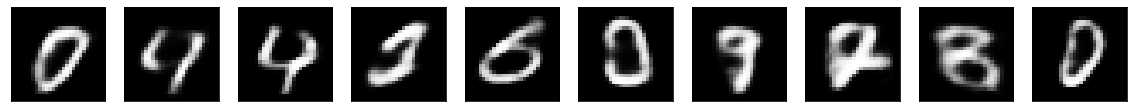

In [41]:
z_sample = np.random.normal(size=(10,latent_dim))
#print(z_sample.shape)
generated = decoder.predict(z_sample)
#print(generated.shape)
plot(generated)